# About
The task is to create a model with the Breast Cancer Wisconsin (Diagnostic) Dataset to answer the question if the 
sample is either `malignant (M)` or `benign (B)`.

Data source: [UC Irvine's webpage](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic).

# Import

In [1]:
import os
from pathlib import Path
from joblib import Parallel, delayed
import joblib

import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px

import pandas as pd
import numpy as np
from scipy.stats import loguniform

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, FixedThresholdClassifier, RandomizedSearchCV, train_test_split
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, accuracy_score, roc_curve, auc, confusion_matrix

# Load data

In [4]:
# Load the dataset
data_path = os.path.join(
    Path(os.getcwd()).parents[1],
    'data/breast_cancer_data.csv'
) 

df = pd.read_csv(data_path)

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


# Check data

In [7]:
df.shape

(572, 33)

* Quite small dataset, moderate number of features

In [9]:
df.isna().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [6]:
assert df['Unnamed: 32'].isna().all()

* No nans, except an extra column  (becuase of trailing comma)

In [8]:
df['id'].nunique() == len(df)

False

In [15]:
df.duplicated(subset=['id']).sum()

np.int64(3)

* Some rows are duplicated

In [16]:
df.duplicated(subset=['id', 'diagnosis']).sum()

np.int64(3)

In [17]:
df.duplicated().sum()

np.int64(3)

In [5]:
df.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [6]:
df['diagnosis'].unique()

array(['M', 'B'], dtype=object)

* All features are continuous and numerical
* Labels are categorical  ('M', 'B')

In [22]:
df.agg(['min', 'max'])

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
min,8670,B,6.981,9.71,43.79,143.5,0.05263,0.01938,0.0000,0.0000,...,12.02,50.41,185.2,0.07117,0.02729,0.000,0.000,0.1565,0.05504,NaN
max,911320502,M,28.110,39.28,188.50,2501.0,0.16340,0.34540,0.4268,0.2012,...,49.54,251.20,4254.0,0.22260,1.05800,1.252,0.291,0.6638,0.20750,NaN


* Features are not normalized

In [10]:
df['diagnosis'].value_counts()

diagnosis
B    360
M    212
Name: count, dtype: int64

* Surprisingly the labels are not too unbalanced, ~2/5 malignant and 3/5 benign

# Process

In [11]:
dfp = df.drop_duplicates()

In [12]:
# drop last column
dfp = dfp.iloc[:, :-1]

# Modeling approach
As a first step choose a simple model. This is a binary classification problem. A simple generalized linear approach is logistic regression. We find relevant features and model parameters by optimizing a suitable metric. 

# Train, test split

In [15]:
yname='diagnosis'

# Use all features except the id 
xnames = [c for c in dfp.columns if c != yname and c != 'id']

In [16]:
xnames

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [17]:
y = dfp['diagnosis']

In [18]:
X = dfp[xnames]
y = dfp[yname]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Normalize features

In [20]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [21]:
# Note: using the same names for raw and normalized features here
X_train = pd.DataFrame(X_train, index=y_train.index, columns=X.columns)

In [22]:
# Simpler to use [0, 1] labels because of defaults in sklearn
y_train = y_train.map({'B': 0, 'M': 1})

In [24]:
# Process also test set
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, index=y_test.index, columns=X.columns)
y_test = y_test.map({'B': 0, 'M': 1})

# Optimize feature subset and model using cross-validation

As a first try, I use a "brute-force" search for all up to triplet combinations of features and varying the model regularization strength, looking for the highest scoring combination. 
This can be done more efficiently using e.g. an feature selection algorithm from https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection.

In [26]:
# Try all 1, 2, 3 feature combinations

feature_combinations = list({
    frozenset([x1, x2, x3])
    for x1 in xnames
    for x2 in xnames
    for x3 in xnames

})
feature_combinations = [sorted(f) for f in feature_combinations]

In [27]:
len(feature_combinations)

4525

In [31]:
model_params_to_vary = {"C": loguniform(1e-3, 1e1)}
model_params_fixed = dict(random_state=0, penalty="l2")
clf = LogisticRegression(**model_params_fixed)
cv_splitter = KFold(n_splits=5, shuffle=True, random_state=0)

search = RandomizedSearchCV(    
        clf,
        param_distributions=model_params_to_vary,
        scoring='f1',
        cv=cv_splitter,
        verbose=False,
        random_state=0,
        # num param values to sample
        n_iter=5,
    )

In [32]:
def optimize_model(features):
    # Perform search
    out = search.fit(X_train[features], y_train)    
    res = pd.DataFrame(out.cv_results_)
    res = res.sort_values("mean_test_score", ascending=False).iloc[0]    
    res['features'] = features
    return res
    

In [35]:
%%time
# Parallelize over features
results = Parallel(n_jobs=-1)(
    delayed(optimize_model)(f)
    #for f in feature_combinations[:10]
    for f in feature_combinations
)

results = pd.concat(results, ignore_index=True, axis=1).T
results = results.sort_values('mean_test_score', ascending=False)

CPU times: user 17 s, sys: 1.26 s, total: 18.3 s
Wall time: 1min 38s


In [36]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,features
2832,0.006429,0.000086,0.006228,0.00008,0.725701,{'C': 0.7257005721594281},0.95082,0.962963,0.953846,0.977778,0.931034,0.955288,0.01533,1,"[perimeter_worst, symmetry_worst, texture_worst]"
345,0.006881,0.001177,0.005371,0.000313,0.725701,{'C': 0.7257005721594281},0.920635,0.962963,0.984615,0.93617,0.965517,0.95398,0.022722,1,"[area_worst, concave points_worst, texture_worst]"
166,0.005529,0.000408,0.005552,0.000707,0.725701,{'C': 0.7257005721594281},0.920635,0.962963,0.984615,0.93617,0.965517,0.95398,0.022722,1,"[concave points_worst, radius_worst, texture_w..."
3275,0.007072,0.000615,0.006485,0.00018,0.725701,{'C': 0.7257005721594281},0.952381,0.964286,0.984615,0.930233,0.928571,0.952017,0.021155,1,"[perimeter_worst, smoothness_worst, texture_wo..."
2777,0.00727,0.000484,0.006698,0.000678,0.725701,{'C': 0.7257005721594281},0.909091,0.964286,0.984615,0.954545,0.947368,0.951981,0.024835,1,"[concave points_mean, radius_worst, texture_wo..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098,0.005475,0.000975,0.005573,0.000082,0.156767,{'C': 0.15676677195506075},0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,"[fractal_dimension_mean, texture_se]"
699,0.005175,0.000525,0.005781,0.000274,0.156767,{'C': 0.15676677195506075},0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,[texture_se]
715,0.005311,0.000138,0.005826,0.000101,0.156767,{'C': 0.15676677195506075},0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,[smoothness_se]
3171,0.005749,0.000294,0.006005,0.000071,0.156767,{'C': 0.15676677195506075},0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,"[fractal_dimension_mean, smoothness_se]"


In [ ]:
results = results.reset_index(drop=True).reset_index(drop=False, ).rename(columns={'index': 'model_rank'})
results['num_features'] = results['features'].apply(len)

results['se_test_score'] = results['std_test_score'] / np.sqrt(cv_splitter.get_n_splits())

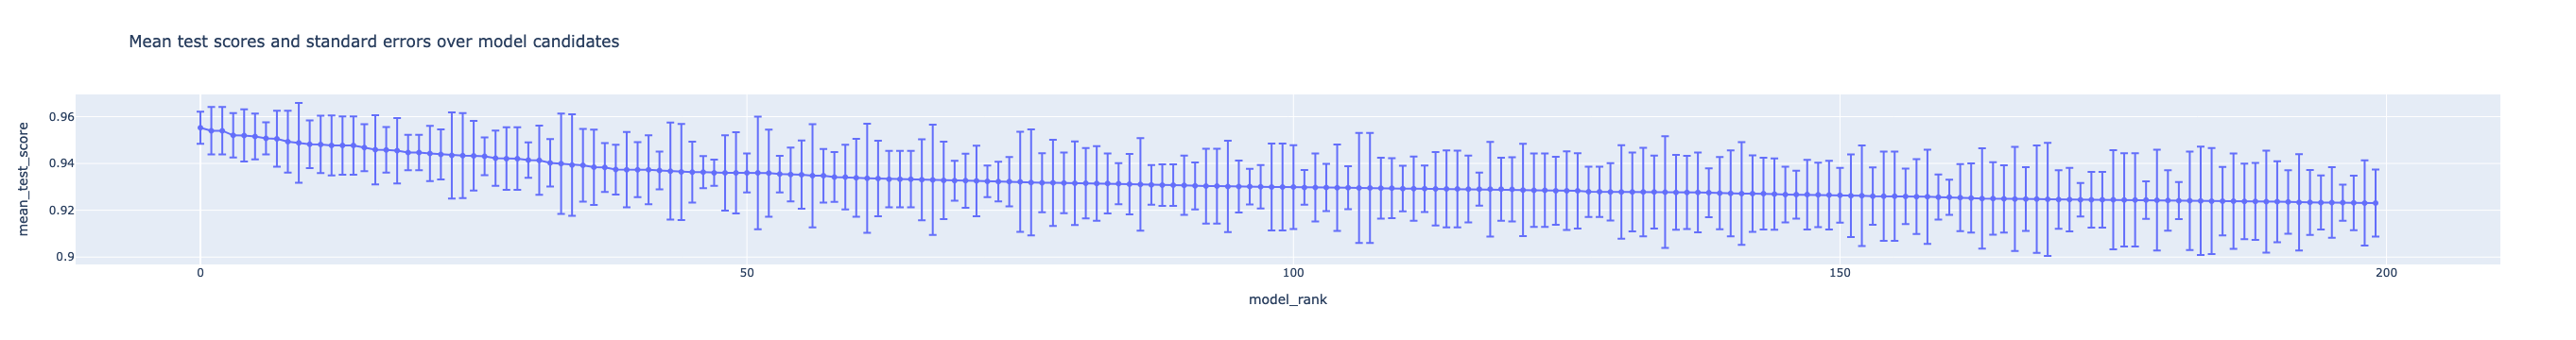

In [44]:
px.line(results.reset_index(drop=True).reset_index(drop=False).iloc[:200], x='model_rank', y='mean_test_score', error_y='se_test_score',  markers=True, title='Mean test scores and standard errors over model candidates', hover_data=['num_features', 'features'])

* All top ranking features sets have the maximum number of features = 3. This indicates that there is likely a benifit in using information from more than than 3 features. 
* Several features combinations are have similar scores, and so are equivalent choices, possibly due to correlation between features.

In [45]:
best = results.iloc[0]

In [46]:
best

model_rank                                                          0
mean_fit_time                                                0.006429
std_fit_time                                                 0.000086
mean_score_time                                              0.006228
std_score_time                                                0.00008
param_C                                                      0.725701
params                                      {'C': 0.7257005721594281}
split0_test_score                                             0.95082
split1_test_score                                            0.962963
split2_test_score                                            0.953846
split3_test_score                                            0.977778
split4_test_score                                            0.931034
mean_test_score                                              0.955288
std_test_score                                                0.01533
rank_test_score     

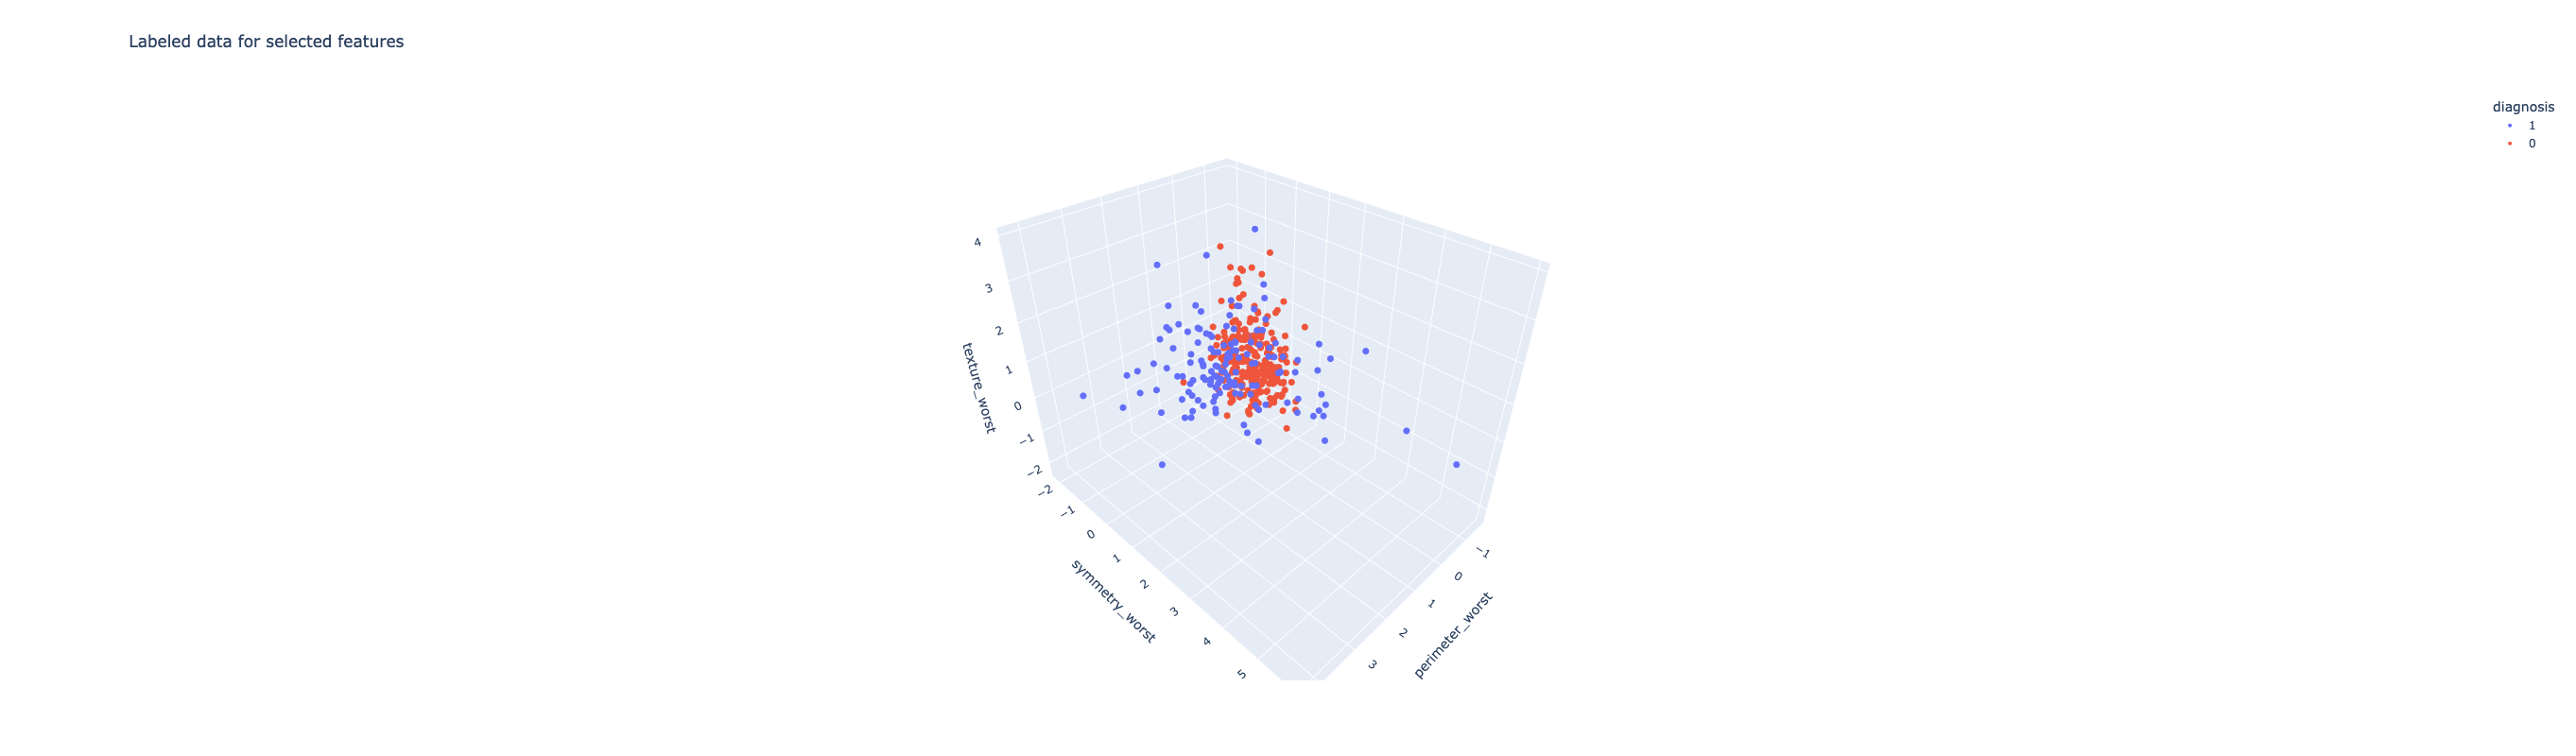

In [47]:
# Eyeball that it makes sense
fig = px.scatter_3d(pd.concat([X_train, y_train], axis=1).astype({'diagnosis': str}), x=best.features[0], y=best.features[1], z=best.features[2], color=yname, title='Labeled data for selected features')
fig.update_traces(marker=dict(size=4))

fig.update_layout(
    width=800,
    height=800,
)

# Threshold tuning
We now have a model for predicting probabilities of malignant/benign. We still have the freedom to choose the probabilty threshold that should separate malignant benign. In this case we can assume that the most important metric is recall, i.e. finding all malignant, and sacrificing some precision as long as the precision is above some minimum tolerance level. This could be replaced by any business metric defining the tradeoff between the error types.

Below I do this tuning again using cross-validation. There is scikitlearn functionality for this, see https://scikit-learn.org/stable/modules/classification_threshold.htmll which we could consider using instead in a next iteration.

In [54]:
def threshold_scores(ytrue, yhat, precision_min=0.8):
    # Calcualte precision, recall and a scoring for all thresholds
    precision, recall, thresholds = precision_recall_curve(ytrue, yhat)
    thresholds = [*thresholds, 1.0]
    scores = np.where(precision > precision_min, recall, precision)
    return scores, thresholds

In [49]:
best

model_rank                                                          0
mean_fit_time                                                0.006429
std_fit_time                                                 0.000086
mean_score_time                                              0.006228
std_score_time                                                0.00008
param_C                                                      0.725701
params                                      {'C': 0.7257005721594281}
split0_test_score                                             0.95082
split1_test_score                                            0.962963
split2_test_score                                            0.953846
split3_test_score                                            0.977778
split4_test_score                                            0.931034
mean_test_score                                              0.955288
std_test_score                                                0.01533
rank_test_score     

In [50]:
clf = LogisticRegression(**model_params_fixed, **best.params)

# The selected features
X_train_best = X_train[best.features]

In [51]:
cv_splitter = KFold(n_splits=5, shuffle=True, random_state=0)

In [55]:
topts = []
for i, (train_index, test_index) in enumerate(cv_splitter.split(X_train_best)):
    # Fit on the train set
    clf_ = clf.fit(X_train_best.iloc[train_index, :], y_train.iloc[train_index])
    probs = clf_.predict_proba(X_train_best.iloc[test_index, :])[:, 1]    
    # Score on the test set
    scores, thresholds = threshold_scores(y_train.iloc[test_index], probs)
    # Maximize score to get optimal threshold
    topt = thresholds[ np.argmax(scores)]          
    topts.append(topt)

# Optimal threshold 
topt = np.mean(topts)
print(topt)

0.2118894484377702


In [56]:
# Tuned classifier, fit on entire train dataset
clf_opt = FixedThresholdClassifier(clf, threshold=topt).fit(X_train_best, y_train)

In [57]:
clf_opt

FixedThresholdClassifier(estimator=LogisticRegression(C=np.float64(0.7257005721594281),
                                                      random_state=0),
                         threshold=np.float64(0.2118894484377702))

# Evaluate on test set
Finally, estimate some model metrics on the test set.

In [58]:
def get_confusion_matrix(ytrue, ypred, **kwargs):
    cm = confusion_matrix(ytrue, ypred, **kwargs)
    cm = pd.DataFrame(cm)
    cm.axes[0].name = "True"
    cm.axes[1].name = "Predicted"    
    return cm
    

In [59]:
# Make predictions on test set using final model
X_test_best = X_test[best.features]
ypred = clf_opt.predict(X_test_best)
probs = clf_opt.predict_proba(X_test_best)[:,1]

In [60]:
# Confusion matrics and other metrics
cm = get_confusion_matrix(y_test, ypred)
display(cm)

print("Metrics on test set:\n"
      f"recall={recall_score(y_test, ypred):.3f}\n"
      f"precision={precision_score(y_test, ypred):.3f}\n"
      f"accuracy={accuracy_score(y_test, ypred):.3f}"
     )

Predicted,0,1
True,,
0,110,11
1,1,66


Metrics on test set:
recall=0.985
precision=0.857
accuracy=0.936


* Recall is very high, precision lower (but still above the minimum tolerance level = 0.8)

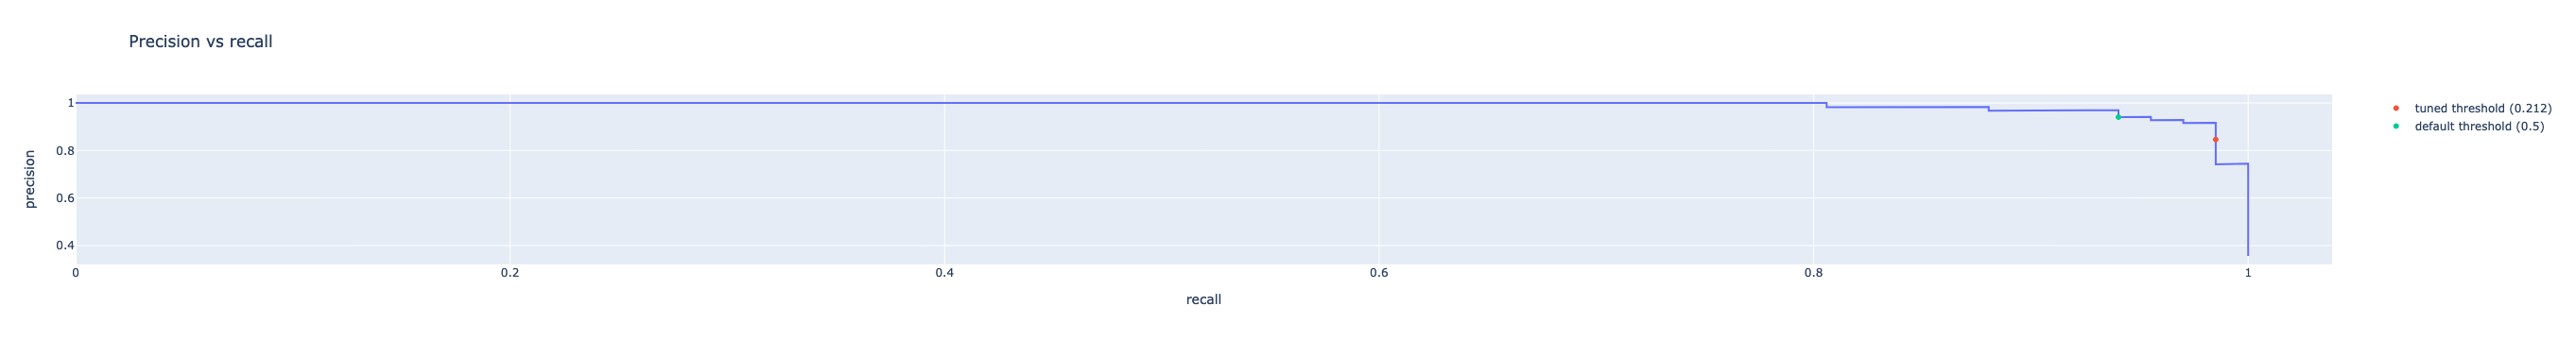

In [62]:
# Precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
thresholds = [*thresholds, 1.0]
df_pr = pd.DataFrame({'precision': precision, 'recall': recall, 'threshold': thresholds})

# Plot precision-recall curve with tuned and default threhsholds points marked out
fig = px.line(df_pr, x='recall', y='precision',  markers=False,  hover_data='threshold', title="Precision vs recall")#width=500, height=500,)

iopt = np.argmin((np.array(thresholds) - topt)**2)
fig.add_trace(go.Scatter(
    x=[df_pr.iloc[iopt].recall],
    y=[df_pr.iloc[iopt].precision],
    mode='markers',
    name=f'tuned threshold ({topt:.3f})',
    )
)


thresh_default = 0.5
idefault = np.argmin((np.array(thresholds) - thresh_default)**2)
fig.add_trace(go.Scatter(
    x=[df_pr.iloc[idefault].recall],
    y=[df_pr.iloc[idefault].precision],
    mode='markers',
    name=f'default threshold ({thresh_default})',
    )
)

fig

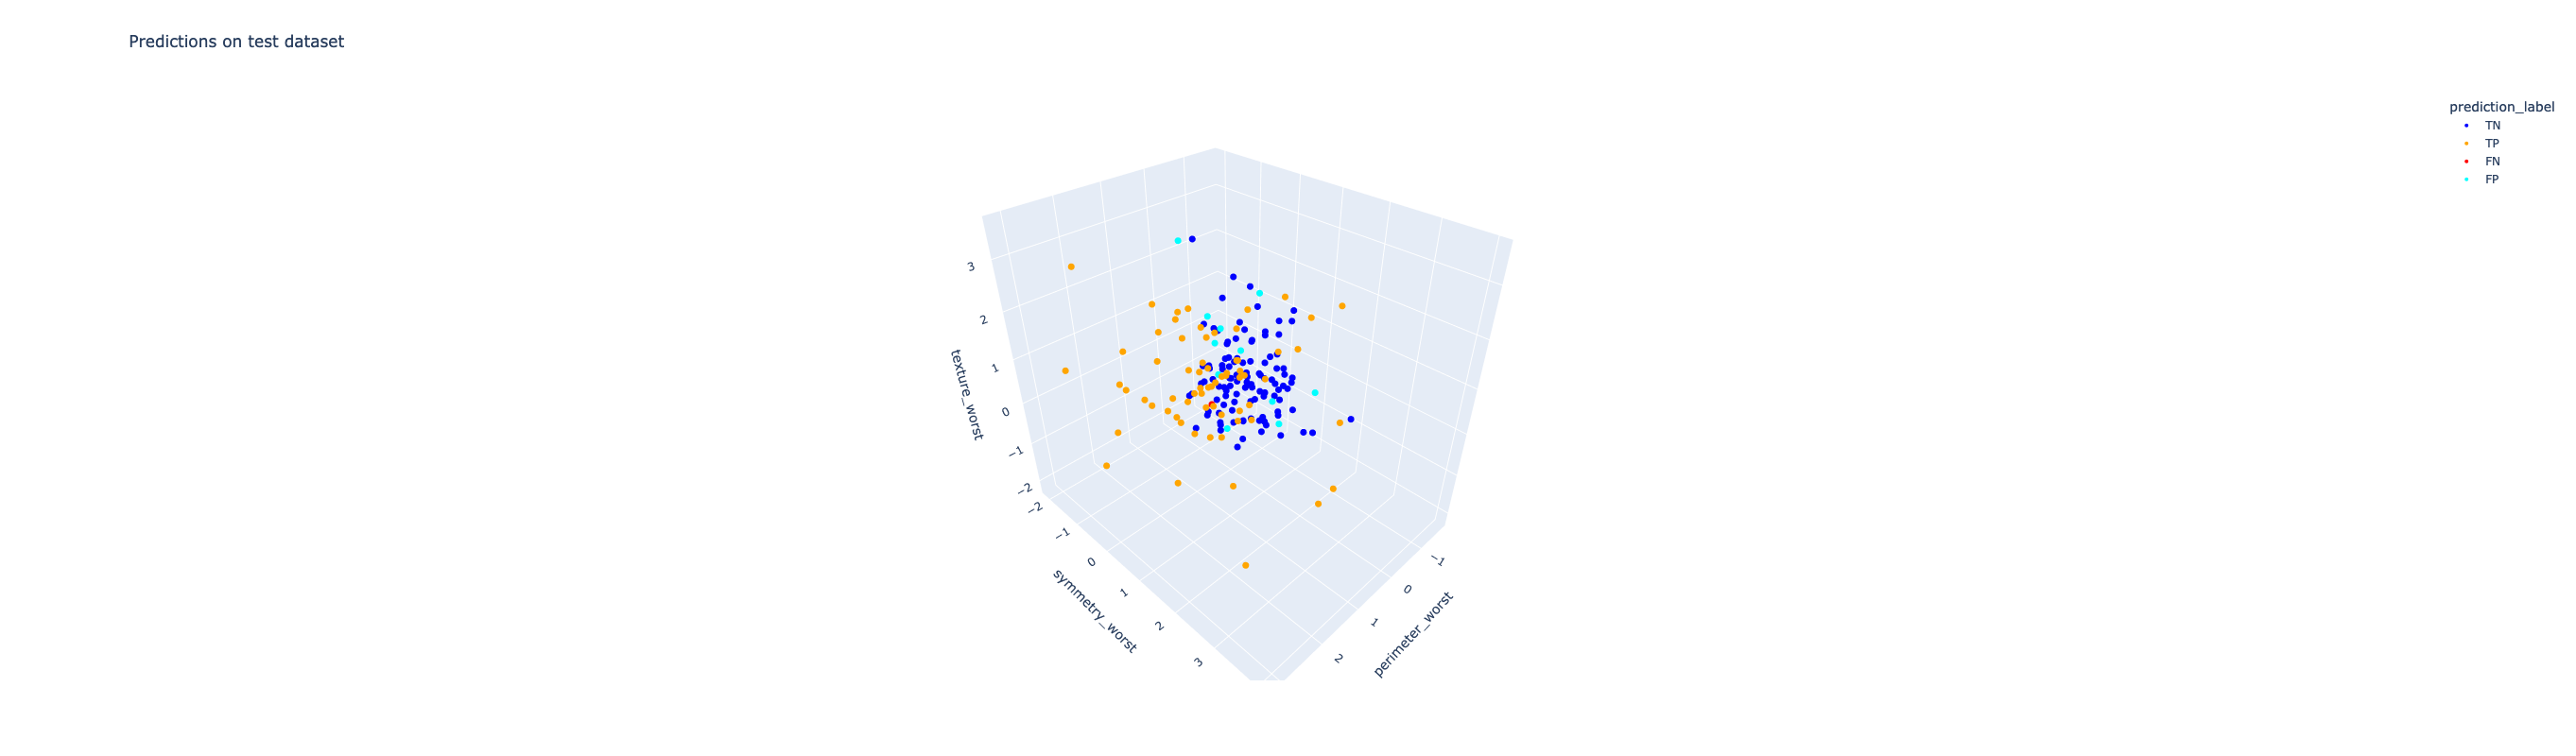

In [63]:
# Visualize prediction and errors, also as a sanity check

tmp = pd.concat([X_test[best.features], y_test], axis=1)
tmp['prediction'] = ypred
tmp['probability'] = probs
tmp['prediction_label'] = tmp[['diagnosis','prediction']].apply(tuple, axis=1).map({(0,0): 'TN', (0, 1): 'FP', (1,0): 'FN', (1,1): 'TP'})

fig = px.scatter_3d(
        tmp,
    color_discrete_map={'TP': 'orange', 'TN': 'blue', 'FN': 'red', 'FP': 'cyan'},
                    x=best.features[0], y=best.features[1], z=best.features[2], color='prediction_label',
    title='Predictions on test dataset'
)
fig.update_traces(marker=dict(size=4))

fig.update_layout(
    width=800,
    height=800,
)

# Train final model

In [64]:
# All data
X_best = X[best.features]

scaler = StandardScaler().fit(X_best)

In [65]:
assert len(dfp) == len(X_best) == len(y)

In [66]:
# Transform and fit
X_best = scaler.transform(X_best)
X_best = pd.DataFrame(X_best, index=y.index, columns=best.features)

clf_opt = clf_opt.fit(X_best, y)

# Export model

In [68]:
joblib.dump(clf_opt, '../../assets/model.pickle')

['../../assets/model.pickle']

In [69]:
joblib.dump(scaler, '../../assets/scaler.pickle')

['../../assets/scaler.pickle']

# Summary and next steps

We now have a first model using logistic regression on 3 of the given features
Model performance is reasonable:
* recall=0.985
* precision=0.857
* accuracy=0.936


To further improve the model I would to begin focus on improving the input features.
The fact that the maximum number of features tested were chosen indicates that there could be more information extracted from a large number of input features.
One could also consider refining the feature space by dimensionality reduction techniques like PCA.